<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 160px;width:200px" float=left>
# Atmospheric Data Analysis: EOF Analysis by Python
## Author: Wei-Ming Tsai
### Modified Date: 06/29/18
---
### Introduction
Emperical orthogonal function (EOF) is a powerful analysis method for exploring spatial structure of varainace in data, and decomposed "modes/EOFs" are physically meanful which might correspond to natural forcings in different time scales. Therefore, this notebook is trying to conduct the EOF analysis by a useful function "eofs", so we can understand more about it step by step.

In [734]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr # for netcdf file
from datetime import datetime

os.chdir('/Users/willytsai/Working-Space/')
os.getcwd()

'/Users/willytsai/Working-Space'

In [735]:
# Read input data
os.chdir('/Users/willytsai/MPO624_data/data/')
#dataset=xr.open_dataset('precip.mon.mean.2008_2017.45NS.nc')
dataset=xr.open_dataset('sst.mnmean.nc')
ds=dataset.sel(time=datetime(2016,7,1),lon=slice(0,360),lat=slice(45,-45)).sst

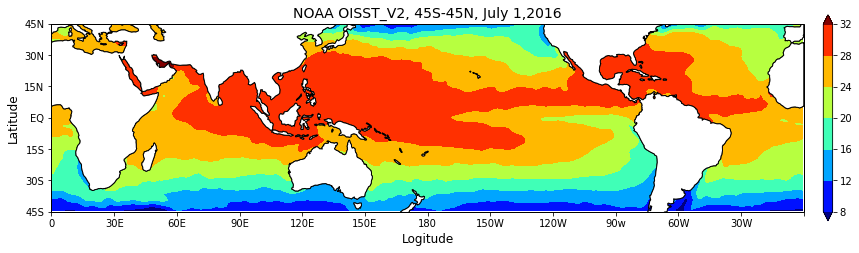

In [736]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(14,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
pcp=xr.plot.contourf(ds,transform=ccrs.PlateCarree(),cmap='jet',robust='true',add_colorbar=False)
ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='w') # maskout LAND
cbar.set_label('[K]',fontsize=12)
cbar=plt.colorbar(pcp,fraction=0.012, pad=0.025);
plt.title('NOAA OISST_V2, 45S-45N, July 1,2016',fontsize=14)
plt.xlabel('Logitude',fontsize=12);plt.ylabel('Latitude',fontsize=12)
plt.xticks(np.linspace(-180,180,13),['0','30E','60E','90E','120E','150E','180','150W','120W','90w'
                                    ,'60W','30W'])
plt.yticks(np.linspace(-45,45,7),['45S','30S','15S','EQ','15N','30N','45N'])
                                    
plt.show()

### (I) select a region and construct the covariance matrix of SST and EOFs
Now we choose "Eastern Pacific", known for ENSO activities, as our EOF example to see the phyiscal and meaningful structure of EOF components

In [737]:
import scipy.signal

ds=dataset.sel(lon=slice(120,300),lat=slice(20,-20)).sst
lons=dataset.sel(lon=slice(120,300),lat=slice(20,-20)).lon.values;
lats=dataset.sel(lon=slice(120,300),lat=slice(20,-20)).lat.values;
sstmn=ds.values[1:433,:,:]; # extract precipitaiton data, lat=15S-15N, lon=120W-80W, 36yrs

# detrend, an important step!! or your EOF1 will be dominated by linear trend
sstmn=scipy.signal.detrend(sstmn[:,:,:],1); 
ssta=sstmn-sstmn.mean(0); # SST anomaly

# remove seasonality
season=np.zeros((12,np.shape(ssta)[1],np.shape(ssta)[2]));
for t in range(12):
    idx=np.int32(np.linspace(t,t+35*12,36))
    season[t,:,:]=ssta[idx,:,:].mean(0);

for t in range(432):
    mon=np.mod(t,12);
    ssta[t,:,:]=ssta[t,:,:]-season[mon,:,:];

In [738]:
# Apply EOF to data anomaly [time, lat, lon] by eofs packages
from eofs.standard import Eof
solver=Eof(ssta)
eof=solver.eofs(neofs=3); # EOF, spatial structure of SSTA
pc=solver.pcs(npcs=3); # Principle components (PC), a timeseris of amplitude
fra=solver.varianceFraction(neigs=3)*100; # explained variance
print 'First 3 EOF:', fra[0:3]
print np.shape(eof)

First 3 EOF: [ 47.04890823   9.75365925   4.81787586]
(3, 40, 180)


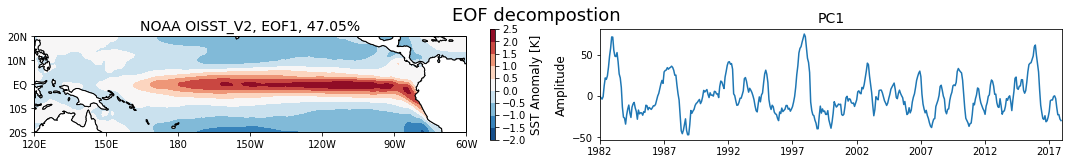

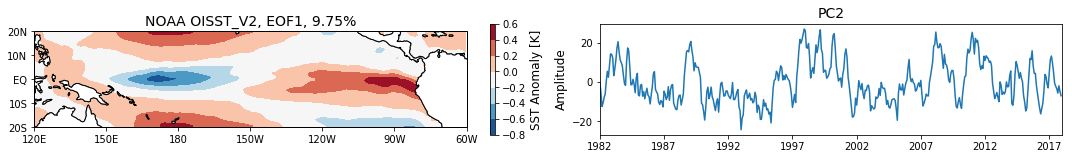

In [739]:
# plot figures 
eofn=2; # select the number of EOFs display

## EOF Display
for n in range(eofn):
    fig=plt.figure(figsize=(15,4))
    ax=fig.add_subplot(eofn,2,2*n+1,projection=ccrs.PlateCarree(central_longitude=210))
    fill = ax.contourf(lons,lats,eof[n].squeeze()*pc[10,n], transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
    ax.coastlines()
    ax.add_feature(cfeat.LAND,zorder=1,facecolor='w',edgecolor='k')
    cb = plt.colorbar(fill,fraction=0.015)
    cb.set_label('SST Anomaly [K]', fontsize=12)
    plt.title('NOAA OISST_V2, EOF1, '+str(np.round(fra[n],decimals=2))+'%', fontsize=14)
    plt.xticks(np.linspace(-90,90,7),['120E','150E','180','150W','120W','90W','60W'])
    plt.yticks(np.linspace(-20,20,5),['20S','10S','EQ','10N','20N'])
    if n==0:
        plt.suptitle('EOF decompostion',fontsize=18)
    
    ax2=fig.add_subplot(eofn,2,2*n+2)
    plt.plot(pc[:,n])
    plt.xlim([0,np.size(ssta,0)])
    plt.xticks(np.linspace(0,420,8),np.int32(np.linspace(1982,2017,8)))
    plt.ylabel('Amplitude',fontsize=12);plt.title('PC'+str(n+1),fontsize=14)
    plt.tight_layout()

plt.show()

### (II) Reconstruction of original data from EOFs 
To varify that our decomposed EOFs are correct, now we are going to reconstruct the "original" data from each EOF components. If the linear combination of all components is able to restore the input "ssta", our EOF analysis is accurate and successful!

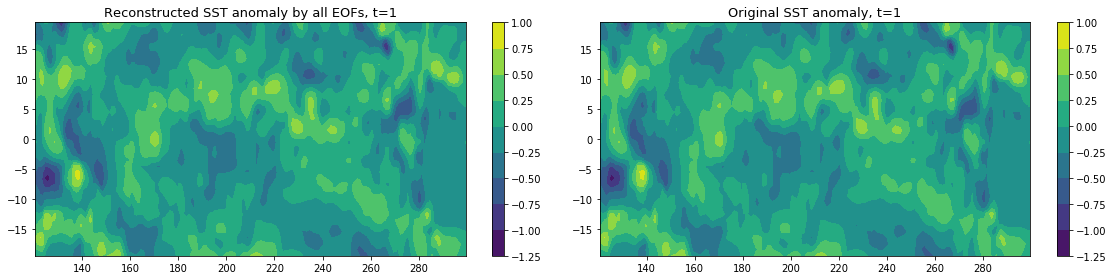

In [740]:
eofall=solver.eofs(); # EOF, spatial structure of SSTA
pcall=solver.pcs(); # Principle components (PC), a timeseris of amplitude

eofall=np.reshape(eofall,((np.shape(eofall)[0],np.shape(eofall)[1]*np.shape(eofall)[2])))
pct1=pcall[0,:];

## SSTA = PC x Eigenvector 
eofsum=np.matmul(pct1,eofall) # reconstructed SST anomaly at t=1

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.contourf(lons,lats,eofsum.reshape(40,180))
plt.colorbar()
plt.title('Reconstructed SST anomaly by all EOFs, t=1',fontsize=13)

plt.subplot(1,2,2)
plt.contourf(lons,lats,ssta[0,:,:]) # SST anomaly at t=1
plt.colorbar()
plt.title('Original SST anomaly, t=1',fontsize=13)

plt.tight_layout()
plt.show()

### <center> Now we see that the reconstructed SSTA is identical to the original SSTA ! <center>